<a href="https://colab.research.google.com/github/JY522IC/PointCloudProject/blob/main/Pointnet_classification0725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The original Pointnet work.
Based on the paper:https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf
Code:https://github.com/Young98CN/pointconv_pytorch
Github: https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/models/pointnet_utils.py


## Install the required libraries

In [ ]:
# install the required libraries
!pip install open3d
!pip install provider

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import the required libaries

In [ ]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm
import open3d as o3d
import numpy as np

# Define the functions

Define the function to load the data

In [ ]:
# input the file path and return the data of all labels
def loadData(path):
    # Load the pcd file
    pcd = o3d.io.read_point_cloud(path)

    # Control the number of points in the point cloud file
    downpcd_farthest = pcd.farthest_point_down_sample(5000)

    point_xyz = np.asarray(downpcd_farthest.points)
    color_rgb = np.asarray(downpcd_farthest.colors)

    return point_xyz,color_rgb

Define the function to normalize the point cloud data to its center position

In [ ]:
def pc_normalize(pc):
    """
    Point data normilization
    :param pc: the pc to normilized
    :return: the point data after normilization
    """
    # the average value
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    # rescale
    pc = pc / m
    return pc

# Define the dataset in the pytorch geometry format

In [ ]:
class Operating_room_classification(InMemoryDataset):

    # Base url to download the files
    # url = 'http://nrvis.com/download/data/labeled/FRANKENSTEIN.zip'

    def __init__(self, root, transform=None, pre_transform=None):
        super(Operating_room_classification, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # List of the raw files
        return []

    @property
    def processed_file_names(self):
        # return list of files should be in processed dir, if found - skip processing
        return ['data.pt']

    # def download(self):
    #     # Download the file specified in self.url and store
    #     # it in self.raw_dir
    #     path = download_url(self.url, self.raw_dir)
    #     extract_zip(path, self.raw_dir)
    #     # The zip file is removed
    #     os.unlink(path)


    def process(self):

      if State == 1:
        df = train_index
      else:
        df = test_index

      # In the loop we extract the nodes' embeddings, edges connectivity for
      # and label for a graph, process the information and put it in a Data
      # object, then we add the object to a list
      data_list = []
      root_new = '/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/Down20000 4'

      for index, row in df.iterrows():

        file_path = os.path.join(root_new, row[1])

        if os.access(file_path, os.F_OK):

          # print(row[1])
          # load the data
          point_pos,color_rgb = loadData(file_path)

          # Normilize the data
          new_points = pc_normalize(point_pos)

          # Calculate the normal information
          device = o3d.core.Device("CPU:0")
          dtype = o3d.core.float64
          pcd = o3d.t.geometry.PointCloud(device)
          pcd.point.positions = o3d.core.Tensor(new_points, dtype, device)
          pcd = pcd.to_legacy()
          radius = 0.01  # Searching Radius
          max_nn = 30  # Number of neighboring points to estimate normal vector
          pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius, max_nn))

          # Convert the position and label information into the Pytorch format
          Pos = torch.tensor(new_points,dtype=torch.float32)
          Y = torch.tensor(row[2],dtype=torch.long)
          Normals = torch.tensor(np.asarray(pcd.normals),dtype=torch.float32)
          Colors = torch.tensor(color_rgb,dtype=torch.float32)

          # Save the data
          graph = Data(pos = Pos, y = Y, normal = Normals, color = Colors)
          data_list.append(graph)
        else:
          pass

        # print(index)

      # Apply the functions specified in pre_filter and pre_transform
      if self.pre_filter is not None:
          data_list = [data for data in data_list if self.pre_filter(data)]

      if self.pre_transform is not None:
          data_list = [self.pre_transform(data) for data in data_list]

      # Store the processed data
      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])

Create the dataset

In [ ]:
import torch_geometric.transforms as T
# load data
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/ChannelFourBasedOnSittingPreparingAndOperating.csv')
train_index=df.sample(frac=0.7)
test_index=df[~df.index.isin(train_index.index)]

# Create the train and test dataset based on the direction
State = 1
trainDataset = Operating_room_classification(root='/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/Dataset/Train')
State = 2
testDataset = Operating_room_classification(root='/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/Dataset/Test')

# Define the Neural Network structure

Main network structure consists of 2 multipy layer perception and 1 main structure

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class STN3d(nn.Module):
    def __init__(self, channel):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetEncoder(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False, channel=3):
        super(PointNetEncoder, self).__init__()
        self.stn = STN3d(channel)
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        B, D, N = x.size()
        trans = self.stn(x)
        x = x.transpose(2, 1)
        if D > 3:
            feature = x[:, :, 3:]
            x = x[:, :, :3]
        x = torch.bmm(x, trans)
        if D > 3:
            x = torch.cat([x, feature], dim=2)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, N)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


def feature_transform_reguliarzer(trans):
    d = trans.size()[1]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2, 1)) - I, dim=(1, 2)))
    return loss

Define the main train structure

In [ ]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

class get_model(nn.Module):
    def __init__(self, k=40, normal_channel=True):
        super(get_model, self).__init__()
        if normal_channel == 2:
            channel = 6
        elif normal_channel == 1:
            channel = 3
        else:
            channel = 9
        self.feat = PointNetEncoder(global_feat=True, feature_transform=True, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x, trans_feat

class get_loss(torch.nn.Module):
    def __init__(self, mat_diff_loss_scale=0.001):
        super(get_loss, self).__init__()
        self.mat_diff_loss_scale = mat_diff_loss_scale

    def forward(self, pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        mat_diff_loss = feature_transform_reguliarzer(trans_feat)

        total_loss = loss + mat_diff_loss * self.mat_diff_loss_scale
        return total_loss

In [ ]:
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

In [ ]:
def test(model, loader, num_class=40, normal_channel=True):
    mean_correct = []
    class_acc = np.zeros((num_class, 3))
    classifier = model.eval()

    for data in testDataLoader:
    #for j, (points, target) in tqdm(enumerate(loader), total=len(loader)):

        # if not args.use_cpu:
        #     points, target = points.cuda(), target.cuda()

        if use_normals == 2:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          new_points = np.concatenate((points,normal),axis=2)
          points = torch.Tensor(new_points)
          points = points.transpose(2, 1)

        elif use_normals == 1:
          points = data.pos
          points = np.asarray(points)

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          points = torch.Tensor(points)
          points = points.transpose(2, 1)
        else:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal
          color = data.color

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          color = np.reshape(color,[int(np.shape(color)[0]/5000),5000,3])

          new_points = np.concatenate((points,normal,color),axis=2)
          points = torch.Tensor(new_points)
          points = points.transpose(2, 1)

        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        # for cat in np.unique(target.cpu()):
        #     classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
        #     class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
        #     class_acc[cat, 1] += 1

        correct = pred_choice.eq(data.y).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    # class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    # class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)

    return instance_acc

In [ ]:
import os
import sys
import torch
import numpy as np

import datetime
import logging
import provider
import importlib
import shutil
import argparse

from pathlib import Path
from tqdm import tqdm
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from sklearn.utils.class_weight import compute_sample_weight
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler

# Define the required parameters
num_class = trainDataset.num_classes
# Number of classes in the dataset
optimizer = 'Adam'
# Define the optimizer used
use_cpu = False
# Whether to use cpu
use_normals = 3
log_dir = None
# Define the log dir
model = 'pointnet_cls'
# The method name used
learning_rate = 0.01
# Define the learning rate
decay_rate = 1e-4
# Deine the decay rate
epoch = 20
# Define the number of epoch in training

# Define the log
def log_string(str):
  logger.info(str)
  print(str)

'''HYPER PARAMETER'''
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

'''CREATE DIR'''
timestr = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
if use_normals == 1:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusThreeChannel')
elif use_normals == 2:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusSixChannelt')
else:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusNineChannel')

exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath('classification')
exp_dir.mkdir(exist_ok=True)
if log_dir is None:
    exp_dir = exp_dir.joinpath(timestr)
else:
    exp_dir = exp_dir.joinpath(args.log_dir)
exp_dir.mkdir(exist_ok=True)
checkpoints_dir = exp_dir.joinpath('checkpoints/')
checkpoints_dir.mkdir(exist_ok=True)
log_dir = exp_dir.joinpath('logs/')
log_dir.mkdir(exist_ok=True)

'''LOG'''
logger = logging.getLogger("Model")
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('%s/%s.log' % (log_dir, model))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
log_string('PARAMETER ...')

# Over Sampling the data
y_label = np.asarray(trainDataset.data.y)
y_weight = compute_sample_weight(class_weight = 'balanced', y = y_label)
Sampler = WeightedRandomSampler(y_weight, len(y_label), replacement=True)

# Load the data
trainDataLoader = DataLoader(trainDataset, batch_size=20, sampler = Sampler)
testDataLoader = DataLoader(testDataset, batch_size=10)

# Load the model
classifier = get_model(num_class, normal_channel=use_normals)
criterion = get_loss()
classifier.apply(inplace_relu)

# if use_cpu == True:
#     classifier = classifier.cuda()
#     criterion = criterion.cuda()

try:
    checkpoint = torch.load(str(exp_dir) + '/checkpoints/best_model.pth')
    start_epoch = checkpoint['epoch']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    log_string('Use pretrain model')
except:
    log_string('No existing model, starting training from scratch...')
    start_epoch = 0

if optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

# Training parameters define
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
global_epoch = 0
global_step = 0
best_instance_acc = 0.0
best_class_acc = 0.0

'''TRANING'''
logger.info('Start training...')
for epoch in range(start_epoch, epoch):
    # log_string('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, epoch))
    mean_correct = []
    classifier = classifier.train()

    scheduler.step()
    for data in tqdm(trainDataLoader, desc='Processing'):
    #for batch_id, (points, target) in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader), smoothing=0.9):
        optimizer.zero_grad()

        # points = points.data.numpy()
        # print(np.shape(points))
        # points = provider.random_point_dropout(points)
        # points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        # points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        if use_normals == 2:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          new_points = np.concatenate((points,normal),axis=2)
          points = torch.Tensor(new_points)
          points = points.transpose(2, 1)

        elif use_normals == 1:
          points = data.pos
          points = np.asarray(points)

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          points = torch.Tensor(points)
          points = points.transpose(2, 1)
        else:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal
          color = data.color

          points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          color = np.reshape(color,[int(np.shape(color)[0]/5000),5000,3])

          new_points = np.concatenate((points,normal,color),axis=2)
          points = torch.Tensor(new_points)
          points = points.transpose(2, 1)
        # if not args.use_cpu:
        #     points, target = points.cuda(), target.cuda()

        # print(data.size)

        # classifier.eval()
        pred, trans_feat = classifier(points)
        loss = criterion(pred, data.y, trans_feat)
        pred_choice = pred.data.max(1)[1]

        correct = pred_choice.eq(data.y).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()
        global_step += 1

    train_instance_acc = np.mean(mean_correct)
    # log_string('Train Instance Accuracy: %f' % train_instance_acc)

    with torch.no_grad():
        instance_acc = test(classifier.eval(), testDataLoader, num_class=num_class, normal_channel=use_normals)

        if (instance_acc >= best_instance_acc):
            best_instance_acc = instance_acc
            best_epoch = epoch + 1

        # if (class_acc >= best_class_acc):
        #     best_class_acc = class_acc
        # log_string('Test Instance Accuracy: %f' % (instance_acc))
        # log_string('Best Instance Accuracy: %f' % (best_instance_acc))

        if (instance_acc >= best_instance_acc):
            # logger.info('Save model...')
            savepath = str(checkpoints_dir) + '/best_model.pth'
            # log_string('Saving at %s' % savepath)
            state = {
                'epoch': best_epoch,
                'instance_acc': instance_acc,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(state, savepath)
        global_epoch += 1
    print(f'Epoch: {epoch:02d}, Train Instance Accuracy: {train_instance_acc:.4f}, Test Accuracy: {instance_acc:.4f}')

# logger.info('End of training...')


<IPython.core.display.Javascript object>

INFO:Model:PARAMETER ...
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
INFO:Model:No existing model, starting training from scratch...
INFO:Model:Start training...
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite ord

PARAMETER ...
No existing model, starting training from scratch...


Processing: 100%|██████████| 135/135 [06:21<00:00,  2.82s/it]


Epoch: 00, Train Instance Accuracy: 0.7062, Test Accuracy: 0.8052


Processing: 100%|██████████| 135/135 [06:19<00:00,  2.81s/it]


Epoch: 01, Train Instance Accuracy: 0.8914, Test Accuracy: 0.5371


Processing: 100%|██████████| 135/135 [06:17<00:00,  2.80s/it]


Epoch: 02, Train Instance Accuracy: 0.9235, Test Accuracy: 0.1819


Processing: 100%|██████████| 135/135 [06:16<00:00,  2.79s/it]


Epoch: 03, Train Instance Accuracy: 0.9052, Test Accuracy: 0.7948


Processing: 100%|██████████| 135/135 [06:18<00:00,  2.81s/it]


Epoch: 04, Train Instance Accuracy: 0.9693, Test Accuracy: 0.9836


Processing: 100%|██████████| 135/135 [06:18<00:00,  2.81s/it]


Epoch: 05, Train Instance Accuracy: 0.9546, Test Accuracy: 0.8586


Processing: 100%|██████████| 135/135 [06:16<00:00,  2.79s/it]


Epoch: 06, Train Instance Accuracy: 0.9732, Test Accuracy: 0.8853


Processing: 100%|██████████| 135/135 [06:18<00:00,  2.81s/it]


Epoch: 07, Train Instance Accuracy: 0.9762, Test Accuracy: 0.9483


Processing: 100%|██████████| 135/135 [06:17<00:00,  2.79s/it]


Epoch: 08, Train Instance Accuracy: 0.9777, Test Accuracy: 0.9319


Processing: 100%|██████████| 135/135 [06:18<00:00,  2.80s/it]


Epoch: 09, Train Instance Accuracy: 0.9737, Test Accuracy: 0.8207


Processing: 100%|██████████| 135/135 [06:18<00:00,  2.80s/it]


Epoch: 10, Train Instance Accuracy: 0.9758, Test Accuracy: 0.9302


Processing: 100%|██████████| 135/135 [06:19<00:00,  2.81s/it]


Epoch: 11, Train Instance Accuracy: 0.9743, Test Accuracy: 0.8509


Processing: 100%|██████████| 135/135 [06:20<00:00,  2.82s/it]


Epoch: 12, Train Instance Accuracy: 0.9756, Test Accuracy: 0.5707


Processing: 100%|██████████| 135/135 [06:21<00:00,  2.83s/it]


Epoch: 13, Train Instance Accuracy: 0.9796, Test Accuracy: 0.9552


Processing: 100%|██████████| 135/135 [06:50<00:00,  3.04s/it]


Epoch: 14, Train Instance Accuracy: 0.9807, Test Accuracy: 0.9707


Processing: 100%|██████████| 135/135 [07:56<00:00,  3.53s/it]


Epoch: 15, Train Instance Accuracy: 0.9838, Test Accuracy: 0.7440


Processing: 100%|██████████| 135/135 [08:29<00:00,  3.77s/it]


Epoch: 16, Train Instance Accuracy: 0.9719, Test Accuracy: 0.9879


Processing: 100%|██████████| 135/135 [09:37<00:00,  4.27s/it]


Epoch: 17, Train Instance Accuracy: 0.9852, Test Accuracy: 0.9129


Processing: 100%|██████████| 135/135 [10:41<00:00,  4.76s/it]


Epoch: 18, Train Instance Accuracy: 0.9835, Test Accuracy: 0.8991


Processing: 100%|██████████| 135/135 [11:44<00:00,  5.22s/it]


Epoch: 19, Train Instance Accuracy: 0.9848, Test Accuracy: 0.9845


In [ ]:
from torch_geometric.loader import DataLoader
trainDataLoader = DataLoader(trainDataset, batch_size=10, shuffle=True)
batch = next(iter(trainDataLoader))

In [ ]:
trainDataLoader = DataLoader(trainDataset, batch_size=10, shuffle=True)
itar = 1
for data in trainDataLoader:
  print(data.size)

  points = data.pos
  points = np.asarray(points)
  normal = data.normal
  print(np.shape(points))
  print(np.shape(normal))
  new_points = np.reshape(points,[trainDataLoader.batch_size,5000,3])
  new_normal = np.reshape(normal,[trainDataLoader.batch_size,5000,3])
  newnew_points = np.concatenate((new_points,new_normal),axis=2)
  print(np.shape(new_points))
  print(np.shape(newnew_points))

  itar += 1
  if itar >10:
    break

# batch = next(iter(trainDataLoader))
# print(batch)
# print(np.shape(np.asarray(batch.pos)))
# print(batch.y)
# a = np.asarray(batch.batch)
# a.flatten()
# print(np.shape(np.asarray(batch.batch)))
# c = [list(a),list(np.asarray(batch.pos))]
# # print(c)
# c = np.array(c)
# print(np.shape([c]))



<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 3])
(10, 5000, 3)
(10, 5000, 6)
<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 3])
(10, 5000, 3)
(10, 5000, 6)
<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 3])
(10, 5000, 3)
(10, 5000, 6)
<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 3])
(10, 5000, 3)
(10, 5000, 6)
<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 3])
(10, 5000, 3)
(10, 5000, 6)
<bound method BaseData.size of DataBatch(y=[10], pos=[50000, 3], normal=[50000, 3], batch=[50000], ptr=[11])>
(50000, 3)
torch.Size([50000, 

In [ ]:
instance_acc = test(classifier.eval(), testDataLoader, num_class=num_class)


# Draw the confusion matrix

Test Accuracy: 1.0000


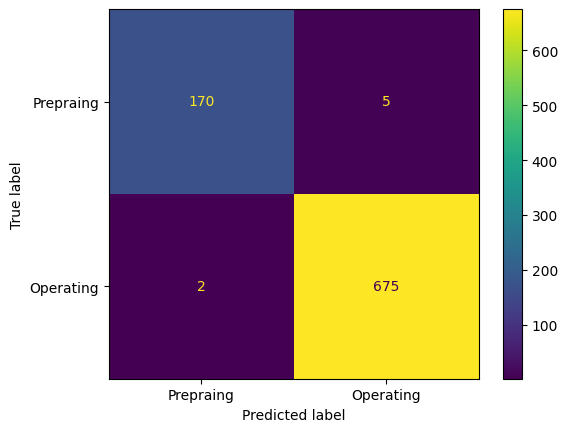

In [ ]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

use_normals = False
num_class = 2

# Load the model
# classifier = get_model(num_class, normal_channel=use_normals)
# criterion = get_loss()
# classifier.apply(inplace_relu)

# # Load the trained network parameters
# checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/TwoClassResult/LogsPointnet/classification/2023-06-15_16-55/checkpoints/best_model.pth')
# start_epoch = checkpoint['epoch']
# classifier.load_state_dict(checkpoint['model_state_dict'])

# Load the test data
testDataLoader = DataLoader(testDataset, batch_size=10)

y_true = []
y_pred = []
with torch.no_grad():
  for data in testDataLoader:
    mean_correct = []

    if use_normals:
      points = data.pos
      points = np.asarray(points)
      normal = data.normal

      points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
      normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
      new_points = np.concatenate((points,normal),axis=2)
      points = torch.Tensor(new_points)
      points = points.transpose(2, 1)

    else:
      points = data.pos
      points = np.asarray(points)

      points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
      points = torch.Tensor(points)
      points = points.transpose(2, 1)

    pred, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]

    y_true.extend(data.y.numpy())
    y_pred.extend(pred_choice.numpy())

    correct = pred_choice.eq(data.y).cpu().sum()
    mean_correct.append(correct.item() / float(points.size()[0]))

# class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
# class_acc = np.mean(class_acc[:, 2])
instance_acc = np.mean(mean_correct)

cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Prepraing','Operating'])
disp.plot()

print(f'Test Accuracy: {instance_acc:.4f}')

TypeError: ignored

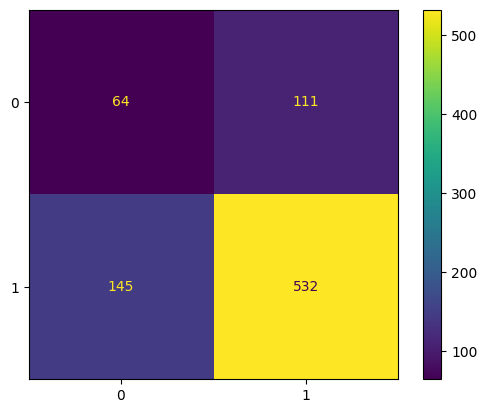

In [ ]:
disp.plot()